In [1]:
!pip install genQC==0.1.0 -q

/bin/bash: /home/ryukijano/miniconda3/envs/cuda-quantum/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Compiling Unitaries Using Diffusion Models

This notebook is based on the work presented in [Quantum circuit synthesis with diffusion models](https://www.nature.com/articles/s42256-024-00615-9), Florian Fürrutter, Gorka Muñoz-Gil & Hans J. Briegel, Nat. Mach. Intell. 6, 515–524 (2024).

Quantum computing relies on efficiently translating quantum operations into viable physical realizations on existing quantum hardware. Recently, diffusion models — a powerful class of generative models in machine learning — have demonstrated exceptional performance on this task.

In notebook, we experiment how to use this method to synthesize arbitrary unitaries into a `cudaq.kernel`, effectively decomposing them into sequences of quantum gates, a process commonly known as unitary compilation.

Our focus will be on generating circuits using a pre-trained model. Specifically, we will illustrate how to compile 3-qubit unitaries.

## Diffusion Model Pipeline

Generative diffusion models (DMs) have recently delivered remarkable results across a wide range of applications, from image generation to protein folding. In this work, we leverage DMs to generate quantum circuits based on a user-specified unitary matrix and a text prompt that defines the allowed gate set, effectively using DMs as unitary compilers. The method is thoroughly explained in Ref. (Fürrutter et al., 2024). The following figure provides an overview of the proposed circuit generation pipeline:

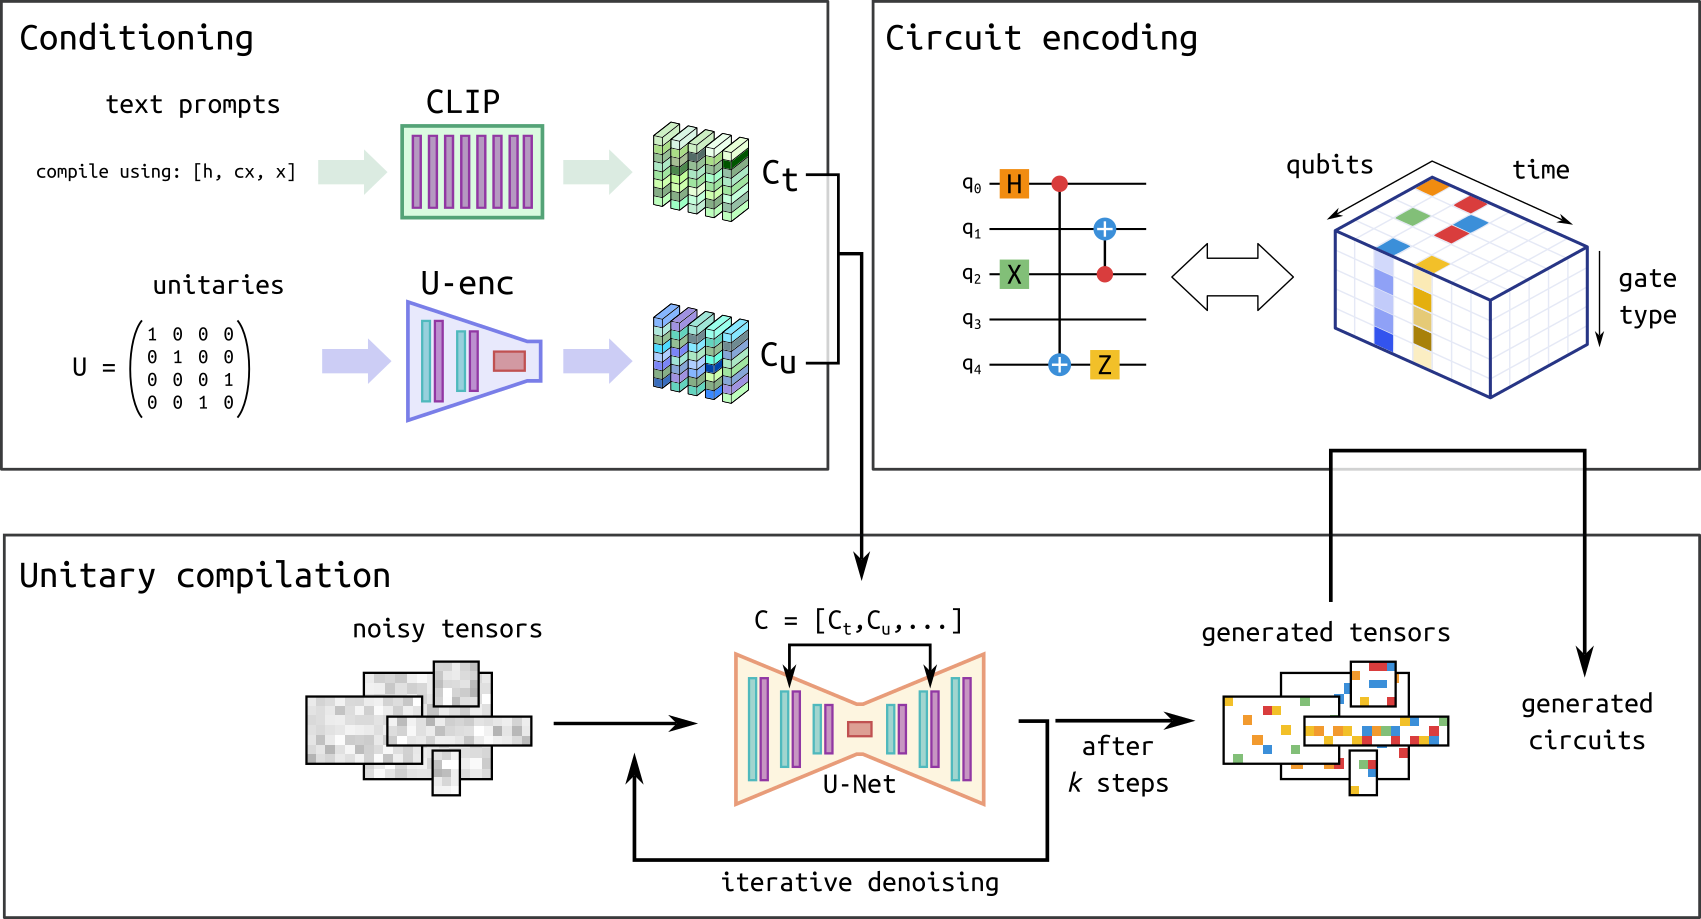

# Quantum Circuit Generation Pipeline

## Overview
This pipeline is designed to generate quantum circuits using diffusion models. It comprises three main components:

### 1. Circuit Encoding
Diffusion models require continuous inputs and outputs, but quantum circuits are composed of discrete gates. To bridge this gap, we develop a mapping that converts each discrete gate into a continuous vector. This transformation allows us to represent a quantum circuit as a three-dimensional tensor. Importantly, this mapping is invertible, enabling us to convert the continuous tensors generated by the diffusion model back into discrete circuit form. The figure below provides an overview of these steps.

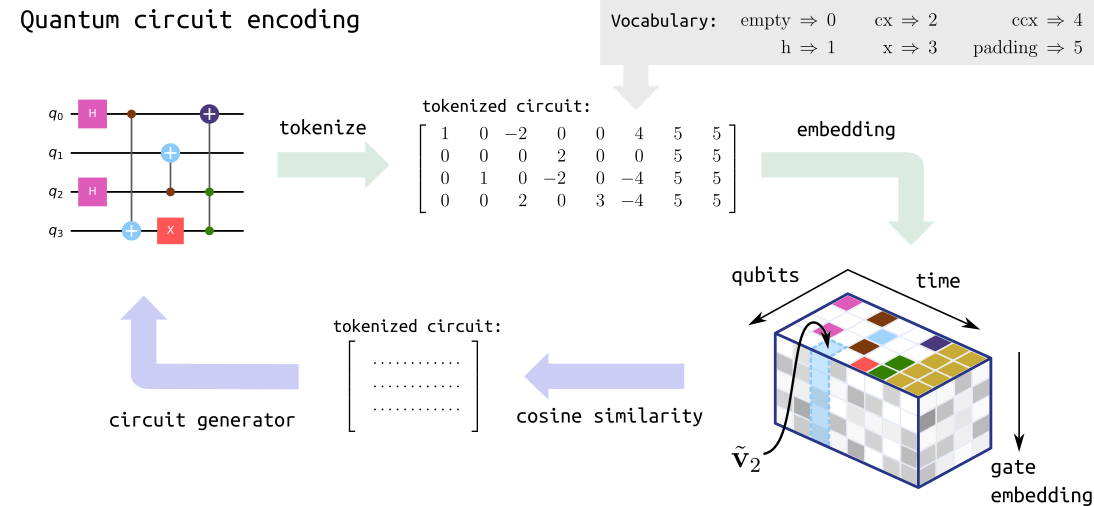

### Quantum Circuit Encoding

Figure adapted from (Fürrutter et al., 2024)

2) **Conditioning**: The user's input, which includes the set of available gates and the unitary to compile, is transformed into a continuous tensor using two neural networks. For the gate set description, provided as a text prompt (e.g., "Compile using ['x', 'h']"), we use a pre-trained language model. For the unitary, a neural network trained jointly with the diffusion model is employed.

3) **Unitary Compilation**: The generation process follows the standard diffusion model (DM) procedure. The model starts with a fully noisy tensor and iteratively de-noises it until a clean sample is obtained, based on the given conditioning (the desired unitary and gate set). The tensors generated by the DM are then mapped to circuits using the inverse encoding procedure. For more details on the practical implementation of diffusion models, we recommend this tutorial.

In the following sections, we will use CUDA-Q and genQC to perform these steps, transforming a desired unitary matrix into a quantum circuit that can be executed using CUDA-Q.

In [2]:
import genQC
from genQC.imports import *
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.inference.export_cudaq import genqc_to_cudaq
import genQC.inference.infer_compilation as infer_comp
import genQC.util as util

import numpy as np
import torch

# Fixed seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [3]:
device = util.infer_torch_device()  # Use CUDA if we can
util.MemoryCleaner.purge_mem()  # Clean existing memory allocation
print(device)

[INFO]: Cuda device has a capability of 8.9 (>= 8), allowing tf32 matmul.
cuda


Loading the model

In [4]:
pipeline = DiffusionPipeline.from_pretrained(
    "Floki00/qc_unitary_3qubit", device)  # Download from Hugging Face
pipeline.scheduler.set_timesteps(40)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.


In [5]:
vocab = {
    i + 1: gate for i, gate in enumerate(pipeline.gate_pool)
}  # Gateset used during training, used for decoding
num_of_qubits = 3  # Number of qubits
max_gates = 12  # Maximum number of gates

### Unitary Compilation

Let’s start by defining the unitary we want to compile. Note that this model has been trained to compile unitaries that arise from circuits composed of the gates contained in `vocab`. While this is a universal gate set (i.e., it can perform universal computation), it can only do so with an infinite number of gates. Because the number of gates in the model is restricted to 12, we can only expect the model to generate unitaries under these constraints. We will consider here the compilation of one such unitary. Nonetheless, stay tuned for bigger and better models!

We start by defining our unitary as a `numpy.matrix`:

In [6]:
U = np.matrix([[0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., -0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [-0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., 0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [0., 0., 0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., 0.70710678, 0., 0., 0.70710678, 0.],
               [0., 0., -0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., -0.70710678, 0., 0., 0.70710678, 0.]],
              dtype=np.complex128)

and check that the matrix is indeed unitary, i.e. \( U^\dagger U = I \) and \( UU^\dagger = I \):

```python
assert np.allclose(U.H @ U, np.identity(2**num_of_qubits)) and np.allclose(U @ U.H, np.identity(2**num_of_qubits))
```

In [7]:
assert np.allclose(U.H @ U, np.identity(2**num_of_qubits)) and np.allclose(
    U @ U.H, np.identity(2**num_of_qubits))  #check if unitary

The loaded model was trained on the gate set `['h', 'cx', 'z', 'x', 'ccx', 'swap']`. It was specifically trained to generate circuits using any arbitrary subset of this gate set. Therefore, during inference, we can instruct the model to compile the unitary using any of these subsets. However, it is crucial to follow the prompt structure `Compile using [...]`, as the model was trained with this specific format. For example, let’s consider a scenario where we compile the unitary without using the `x` gate:

In [8]:
# Notice how the x gate missing from the prompt since this is a restriction we set
prompt = "Compile using: ['h', 'cx', 'z', 'ccx', 'swap']"

Now, we use the diffusion model pipeline to generate encoded circuits based on the specified conditions: prompt and U. A significant advantage of this approach is the rapid sampling of new circuits once the model is trained. Under the same conditions defined above, we will generate 128 circuits and analyze them in the following sections.

In [9]:
# Number of circuits to sample from the trained DM.
samples = 128

# As the neural network works only with real numbers, we first separate
# the two components and create a 2 dimensional tensor for the magnitude
# of each component:
U_r, U_i = torch.Tensor(np.real(U)), torch.Tensor(np.imag(U))
U_tensor = torch.stack([U_r, U_i], dim=0)

# Now we generate a tensor representation of the desired quantum circuit using the DM based on the prompt and U. This is also known as inference.
out_tensors = infer_comp.generate_comp_tensors(
    pipeline=pipeline,
    prompt=prompt,
    U=U_tensor,
    samples=samples,
    system_size=
    num_of_qubits,  # Max qubit number allowed by the model (this model is only trained with 3 qubits)
    num_of_qubits=num_of_qubits,
    max_gates=max_gates,
    g=10  # classifier-free-guidance (CFG) scale
)

In [10]:
out_tensors[0]

tensor([[ 5,  3,  0,  0, -5,  3,  3,  0, -5,  0,  0,  0],
        [-5,  0,  0,  6,  5,  0,  0,  3,  5,  0,  0,  0],
        [-5,  0,  1,  6, -5,  0,  0,  0, -5,  0,  0,  0]])

### Convert Tensors to CUDA-Q

Next, we convert the generated tensors into `cudaq.kernels`.

In [11]:
import cudaq

#cudaq.set_target('qpp-cpu')  # Note that cpu is faster for 3 qubit kernels

cudaq.set_target('nvidia') # Set to GPU for larger circuits

In [12]:
import tqdm

In [13]:
kernel_list = []
valid_tensors = []

invalid_tensors = 0
for out_tensors_i in tqdm.tqdm(out_tensors):
    
    # Use a try-except to catch invalid tensors (if any)
    try:
        kernel = genqc_to_cudaq(out_tensors_i,
                                vocab)  # Convert out_tensors to CUDA-Q kernels
    except:
        kernel = None

    if kernel:
        kernel_list.append(kernel)
        valid_tensors.append(out_tensors_i)
    else:
        invalid_tensors += 1

print(
    f"The model generated {invalid_tensors} invalid tensors that does not correspond to circuits."
)

100%|██████████| 128/128 [00:01<00:00, 94.08it/s]

The model generated 0 invalid tensors that does not correspond to circuits.


In [14]:
valid_tensors[0]

tensor([[ 5,  3,  0,  0, -5,  3,  3,  0, -5,  0,  0,  0],
        [-5,  0,  0,  6,  5,  0,  0,  3,  5,  0,  0,  0],
        [-5,  0,  1,  6, -5,  0,  0,  0, -5,  0,  0,  0]])

In [15]:
# Arbitrary input state to the circuit for plotting

input_state = [0] * (2**num_of_qubits)

print(cudaq.draw(kernel_list[0], input_state))

     ╭───╮╭───╮        ╭───╮╭───╮     
q0 : ┤ x ├┤ z ├─────●──┤ z ├┤ z ├──●──
     ╰─┬─╯╰───╯   ╭─┴─╮├───┤╰───╯╭─┴─╮
q1 : ──●────────╳─┤ x ├┤ z ├─────┤ x ├
       │  ╭───╮ │ ╰─┬─╯╰───╯     ╰─┬─╯
q2 : ──●──┤ h ├─╳───●──────────────●──
          ╰───╯                       



### Evaluate Generated Circuits

One of the key advantages of using diffusion models (DMs) as a unitary compiler is the ability to rapidly sample many circuits. However, due to the inherent accuracy limitations of machine learning models, not all generated circuits are expected to exactly compile the specified unitary. In this section, we will evaluate the generated circuits to determine how many correctly compile the specified unitary. We will then perform post-selection to identify at least one circuit that successfully performs the desired unitary operation.

### Simulate Kernels

First, we calculate the unitary matrix implemented by each of the kernels. The elements of this matrix are defined by the transition amplitudes between the basis states, which can be expressed as:

\[ U_{ij} = \langle i | U | j \rangle \]

where \( |i\rangle \) and \( |j\rangle \) are computational basis states (typically in the \( z \)-basis), with \( |i\rangle \) representing the standard basis vector that has a 1 in the \( i \)-th position and 0 elsewhere.

In [17]:
from tqdm.auto import tqdm

In [18]:
N = 2**num_of_qubits
got_unitaries = np.zeros((len(kernel_list), N, N), dtype=np.complex128)

for i, kernel in enumerate(tqdm(kernel_list, total=len(kernel_list))):
    for j in range(N):
        basis_state_j = np.zeros((N), dtype=np.complex128)
        basis_state_j[j] = 1

        got_unitaries[i, :,
                      j] = np.array(cudaq.get_state(kernel, basis_state_j),
                                    copy=False)

  0%|          | 0/128 [00:00<?, ?it/s]

In [19]:
np.set_printoptions(linewidth=1000)
print(np.round(got_unitaries[0], 4))

[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]]


### Compare Unitaries

Now that we have the unitaries for each of the kernels, we compare them to the user-provided unitary matrix \( U \). To do so, we compute the infidelity between the exact unitary and the generated ones. The infidelity is a value between 0 and 1, where 0 indicates that the unitaries are identical (up to a global phase).

In [20]:
def infidelity(want_unitary, got_unitary):
    return 1 - np.abs(
        np.trace(np.conj(want_unitary).T @ got_unitary) / 2**num_of_qubits)**2


infidelities = np.array(
    [infidelity(U, got_unitary) for got_unitary in got_unitaries])

Let’s now plot a histogram of the infidelities for our generated circuits:

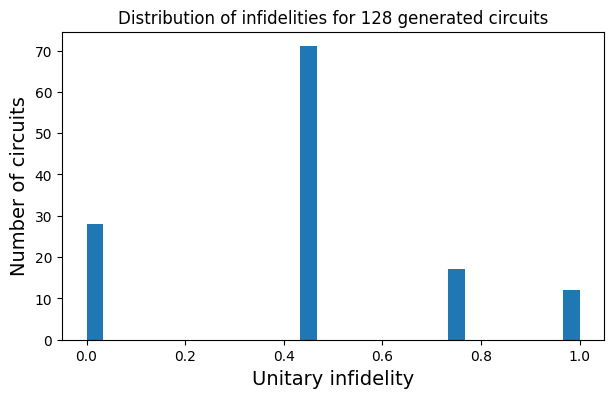

In [21]:
plt.figure(figsize=(7, 4))
plt.title(
    f"Distribution of infidelities for {len(got_unitaries)} generated circuits",
    fontsize=12)
plt.ylabel("Number of circuits", fontsize=14)
plt.xlabel("Unitary infidelity", fontsize=14)
plt.hist(infidelities, bins=30)
plt.show()

As observed, the model successfully generated nearly 30 circuits that compile the unitary with an infidelity close to or equal to zero. The kernel with the lowest infidelity is:

In [22]:
min_index = np.argmin(infidelities)

print(f"The best kernel has an infidelity of {infidelities[min_index]:0.2},")

input_state = [0] * (2**num_of_qubits)
input_state[0] = 1
print(cudaq.draw(kernel_list[min_index], input_state))

print(f"with the unitary:")
print(np.round(got_unitaries[min_index], 4))

The best kernel has an infidelity of 3.8e-08,
     ╭───╮╭───╮        ╭───╮╭───╮     
q0 : ┤ x ├┤ z ├─────●──┤ z ├┤ z ├──●──
     ╰─┬─╯╰───╯   ╭─┴─╮├───┤╰───╯╭─┴─╮
q1 : ──●────────╳─┤ x ├┤ z ├─────┤ x ├
       │  ╭───╮ │ ╰─┬─╯╰───╯     ╰─┬─╯
q2 : ──●──┤ h ├─╳───●──────────────●──
          ╰───╯                       

with the unitary:
[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.   

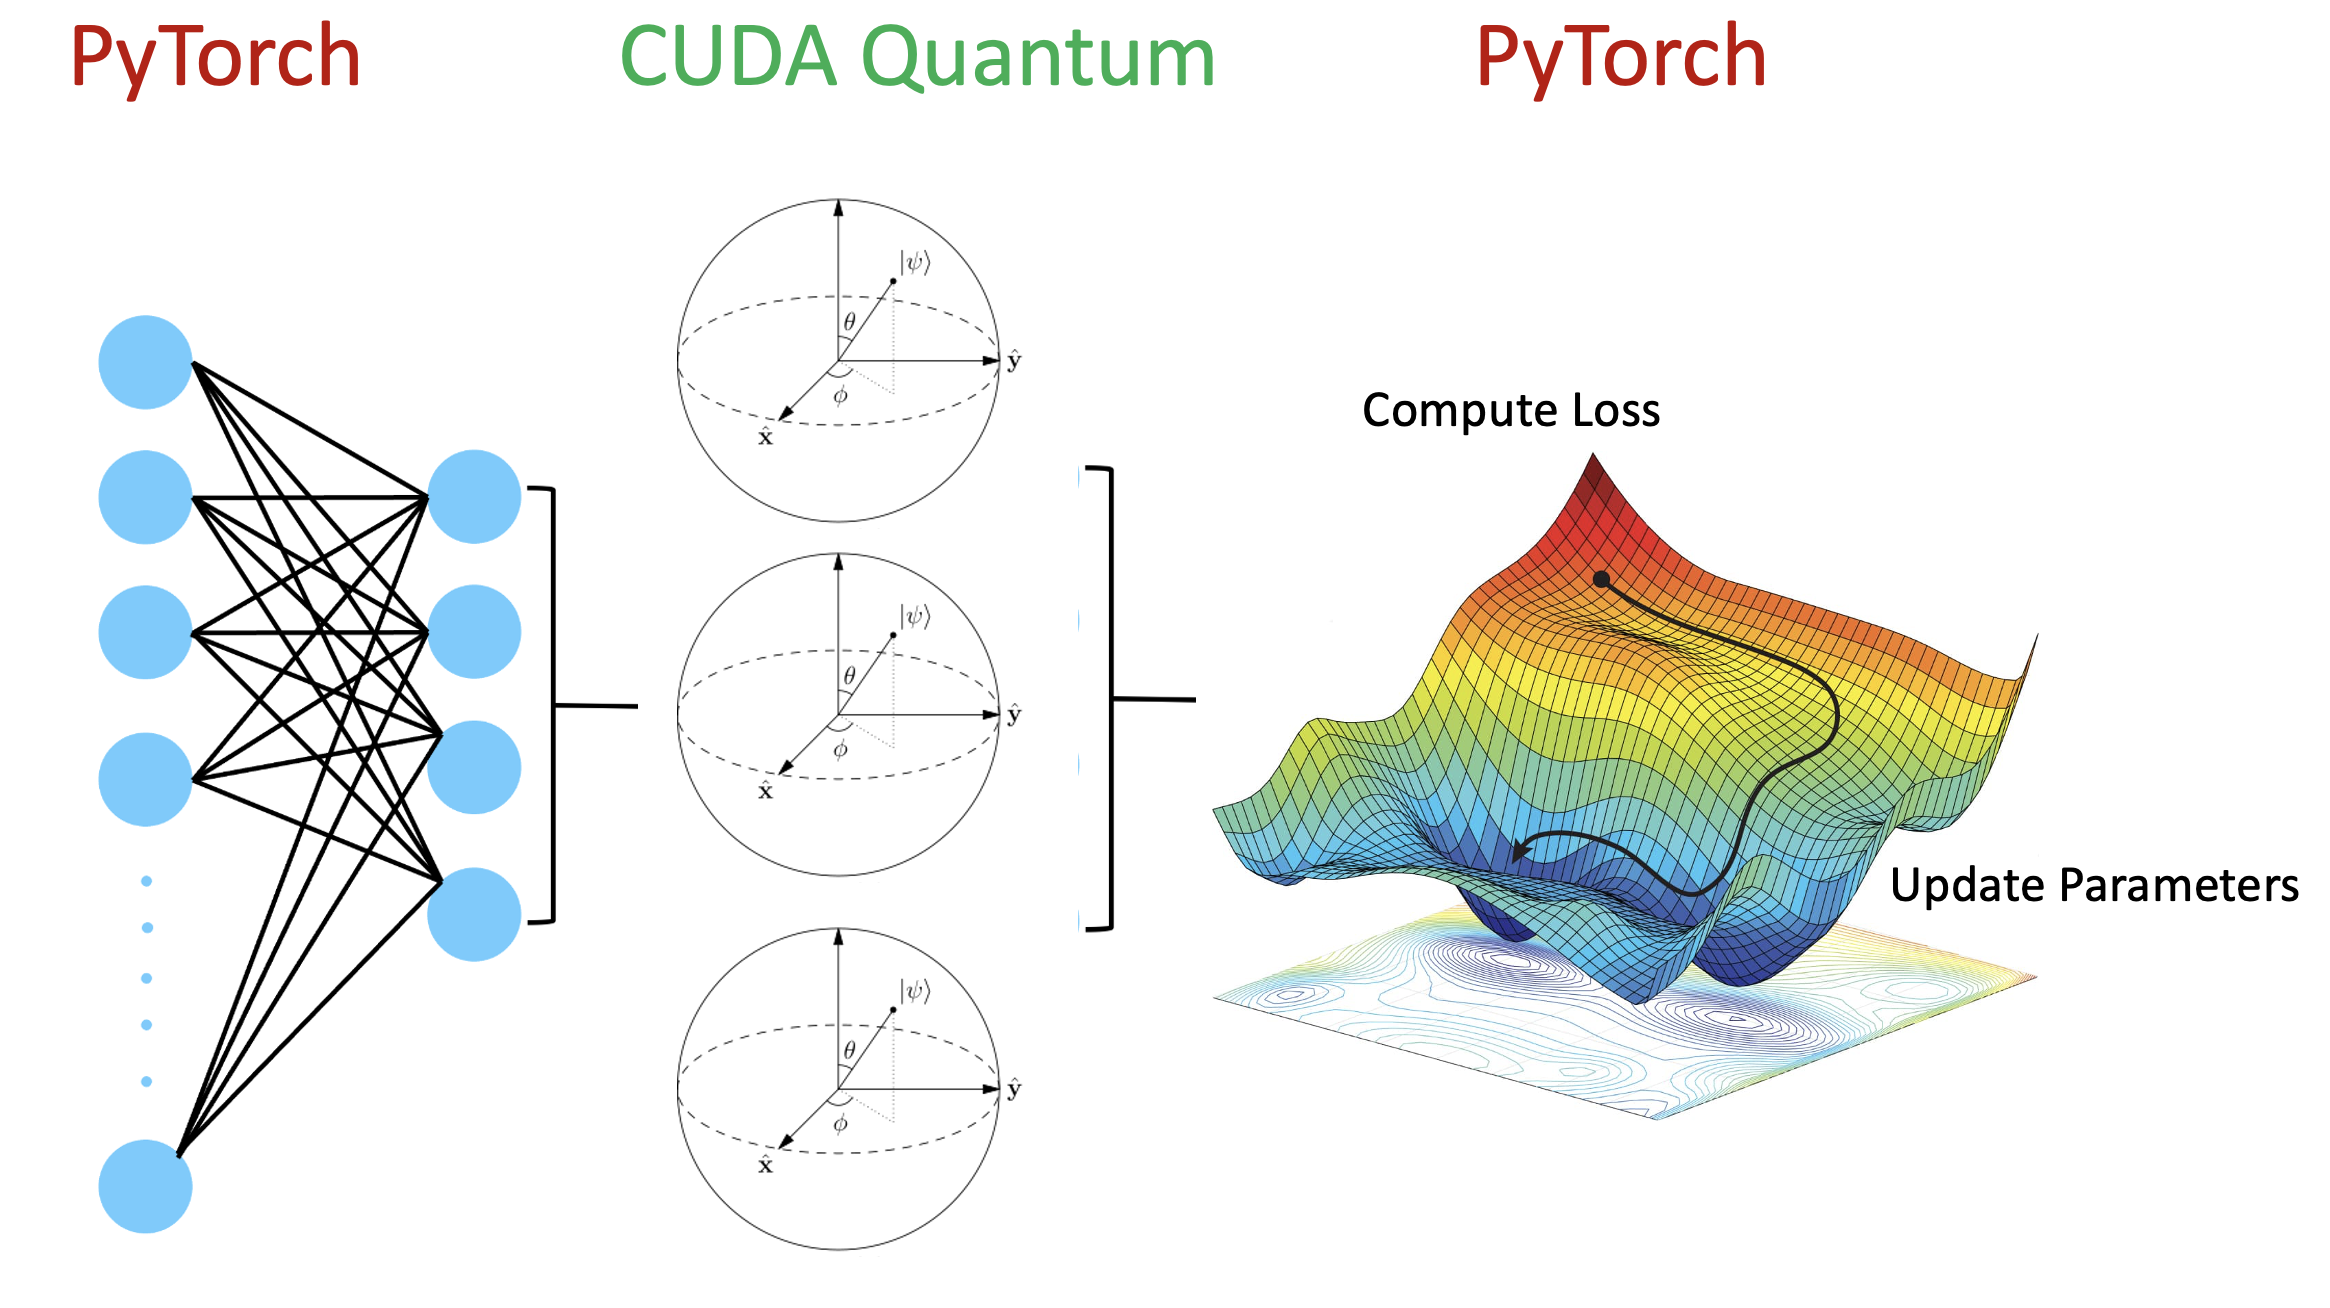

In [23]:
print(np.round(U, 4))

[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]]


### Choosing the Circuit You Need

As observed above, we now have nearly 30 kernels that compile the desired unitary! This is particularly valuable when dealing with hardware constraints, where, for instance, we might want to avoid using certain qubits or specific gates. One practical example is finding the circuit with the fewest Toffoli gates (also known as ccx). In our vocab definition above, we identified that ccx corresponds to the label 5 in our tokenized tensors. Let’s use this information to search for the circuit that minimizes the number of ccx gates:

In [ ]:
# First, we remove possible duplicates and only pick distinct circuits
_, idx_unique = np.unique(np.array(valid_tensors), axis=0, return_index=True)
unique_tensors = torch.stack(valid_tensors)[idx_unique]
unique_infidelities = infidelities[idx_unique]
unique_kernels = [kernel_list[idx] for idx in idx_unique]

# Then, find the correct circuits
idx_correct = torch.argwhere(torch.tensor(unique_infidelities) < 0.01).flatten()
correct_tensors = unique_tensors[idx_correct]
print(
    f"The model generated {correct_tensors.shape[0]} distinct correct circuits."
)

# Now let's flatten the last two dimensions (related to the actual circuit) and find out how many 5's (i.e. ccx) gates each circuit has:cd
num_ccx = (correct_tensors.flatten(1, 2) == 5).sum(1)
print("These circuits have this number of ccx gates:", num_ccx)

The model generated 16 distinct correct circuits.
These circuits have this number of ccx gates: tensor([1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1])


As observed, the diffusion model (DM) necessitates at least one Toffoli gate to compile the unitary. We can now print several of these circuits to choose the one that best fits our requirements or to examine any intriguing patterns the model uses for this specific unitary.

In [25]:
# Get the correct kernels
correct_kernels = [unique_kernels[idx] for idx in idx_correct]

# Get the ones with only one ccx
correct_kernels_ccx1 = [
    correct_kernels[idx] for idx in torch.argwhere(num_ccx == 1).flatten()
]

# Draw a few of this circuits
for kernel in correct_kernels_ccx1[:3]:
    print(cudaq.draw(kernel, input_state))

        ╭───╮╭───╮               
q0 : ───┤ x ├┤ z ├───────●───────
        ╰─┬─╯├───┤╭───╮  │       
q1 : ─╳───●──┤ h ├┤ z ├──┼───────
      │   │  ├───┤╰───╯╭─┴─╮╭───╮
q2 : ─╳───●──┤ h ├─────┤ x ├┤ h ├
             ╰───╯     ╰───╯╰───╯

     ╭───╮╭───╮             
q0 : ┤ x ├┤ z ├──●──────────
     ╰─┬─╯├───┤╭─┴─╮        
q1 : ──●──┤ h ├┤ x ├─╳──────
       │  ├───┤├───┤ │ ╭───╮
q2 : ──●──┤ h ├┤ z ├─╳─┤ h ├
          ╰───╯╰───╯   ╰───╯

     ╭───╮╭───╮             
q0 : ┤ x ├┤ z ├─────●───────
     ╰─┬─╯├───┤     │  ╭───╮
q1 : ──●──┤ h ├─╳───┼──┤ z ├
       │  ├───┤ │ ╭─┴─╮├───┤
q2 : ──●──┤ h ├─╳─┤ x ├┤ h ├
          ╰───╯   ╰───╯╰───╯



In [26]:
print(cudaq.__version__)
print("genQC Version", genQC.__version__)

CUDA-Q Version 0.8.0 (https://github.com/NVIDIA/cuda-quantum 5f63a898a1c4af1affd293fcc86220b683436f57)
genQC Version 0.1.0
